# Setup
Inizia installando e importando alcune librerie necessarie, tra cui: `tqdm` per utilizzare una barra di avanzamento, `OpenCV` per elaborare file video, `einops` per eseguire operazioni tensoriali più complesse e `tensorflow_docs` per incorporare i dati in un notebook Jupyter.

In [2]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow==2.10.0"
!pip install -U "einops"

In [3]:
!pip install tqdm opencv-python numpy matplotlib imageio seaborn pydot
!pip install tensorflow-docs

In [4]:
import seaborn as sns

import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np

import tensorflow as tf

import shutil #roba fresca aggiunta da poco
import matplotlib.pyplot as plt 

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

import keras
from keras import layers
import einops

# Fase di Pre-processing
Si noti che il nome della classe è incluso nel nome del file di ogni video.

Definire la funzione `get_class` che recupera il nome della classe da un nome di file. Quindi, creare una funzione chiamata `get_files_per_class` che converte l'elenco di tutti i file (file sopra) in un dizionario che elenca i file per ogni classe:

In [5]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-7]

In [6]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

Il seguente blocco serve per contare i file video di tipo `*.avi `in tutte le sottocartelle del dataset

In [7]:
download_dir = pathlib.Path("D:/Gruppo_24_FVAB/videos/")

video_count_train = len(list(download_dir.glob('Train/*/*.avi')))
video_count_val = len(list(download_dir.glob('Validation/*/*.avi')))
video_count_test = len(list(download_dir.glob('Test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 1280


# Crea fotogrammi da ogni file video

La funzione `frames_from_video_file` divide i video in frame, legge un intervallo scelto a caso di `n_frame` da un file video e li restituisce come `array` NumPy. Per ridurre la memoria e il sovraccarico di calcolo, scegliere un piccolo numero di fotogrammi. Inoltre, scegli lo stesso numero di fotogrammi da ogni video, il che rende più facile lavorare su lotti di dati.


In [8]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [9]:
def frames_from_video_file(video_path, n_frames, output_size = (80, 120), frame_step = 3):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.  altezza*larghezza

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

# Visualizza i dati video

Snippet di 
codice per fare un gif dato un video preso a caso nella cartella di Train


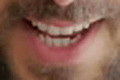

In [10]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=125)
  return embed.embed_file('./animation.gif')

# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(download_dir.glob('Train/*/*.avi')), 80)
to_gif(ucf_sample_video)

Successivamente, definire la classe `FrameGenerator` per creare un oggetto iterabile in grado di immettere dati nella pipeline di dati TensorFlow. La funzione generatore `(__call__)` produce l'array di frame prodotto da `frames_from_video_file` e un vettore codificato one-hot dell'etichetta associata all'insieme di frame.

In [11]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Creiamo il training, il  validation e il test sets (train_ds, val_ds, test_ds).

In [12]:
n_frames = 80
batch_size = 32

train_dir = pathlib.Path("D:/Gruppo_24_FVAB/videos/Train")
test_dir = pathlib.Path("D:/Gruppo_24_FVAB/videos/Test")
val_dir = pathlib.Path("D:/Gruppo_24_FVAB/videos/Validation")

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_dir, n_frames, training=True),
                                          output_signature = output_signature)

# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_dir, n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_dir, n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

# Creazione del modello


Il seguente modello di rete neurale convoluzionale 3D si basa sul documento A Closer Look at Spatiotemporal Convolutions for Action Recognition di D. Tran et al. (2017). Il documento confronta diverse versioni di 3D ResNets. Invece di operare su una singola immagine con dimensioni `(altezza, larghezza)`, come le ResNet standard, queste operano sul volume video `(tempo, altezza, larghezza)`. L'approccio più ovvio a questo problema sarebbe sostituire ogni convoluzione 2D `(layers.Conv2D)` con una convoluzione 3D `(layers.Conv3D)`.

Questo progetto utilizza una convoluzione (2 + 1)D con connessioni residue. La convoluzione (2 + 1)D consente la decomposizione delle dimensioni spaziali e temporali, creando quindi due passaggi separati. Un vantaggio di questo approccio è che la fattorizzazione delle convoluzioni in dimensioni spaziali e temporali salva i parametri.

Per ogni posizione di uscita una convoluzione 3D combina tutti i vettori da una patch 3D del volume per creare un vettore nel volume di uscita.
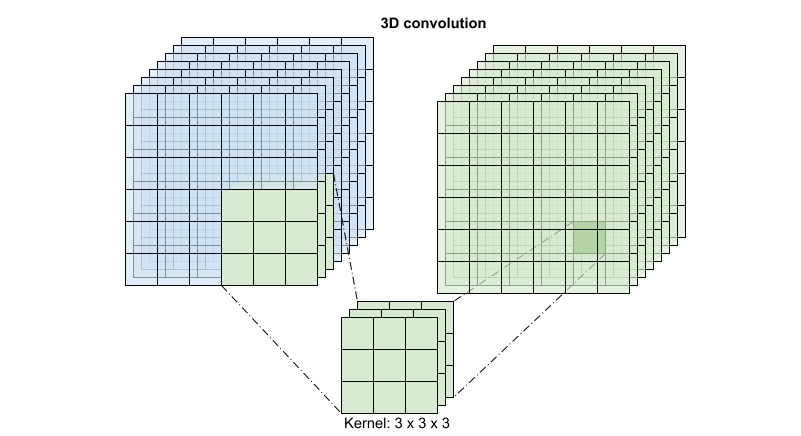

Questa operazione richiede `time * height * width * channels` inputs e produce `channels` uscite (supponendo che il numero di canali di ingresso e di uscita siano gli stessi. Quindi un livello di convoluzione 3D con una dimensione del kernel di `(3 x 3 x 3)` avrebbe bisogno di una matrice di peso con `27 * channels ** 2` voci. Il documento di riferimento ha rilevato che un approccio più efficace ed efficiente era quello di fattorizzare la convoluzione. Invece di una singola convoluzione 3D per elaborare le dimensioni del tempo e dello spazio, hanno proposto una convoluzione "(2+1)D" che elabora le dimensioni dello spazio e del tempo separatamente. La figura seguente mostra le convoluzioni spaziali e temporali fattorizzate di una convoluzione (2 + 1)D.
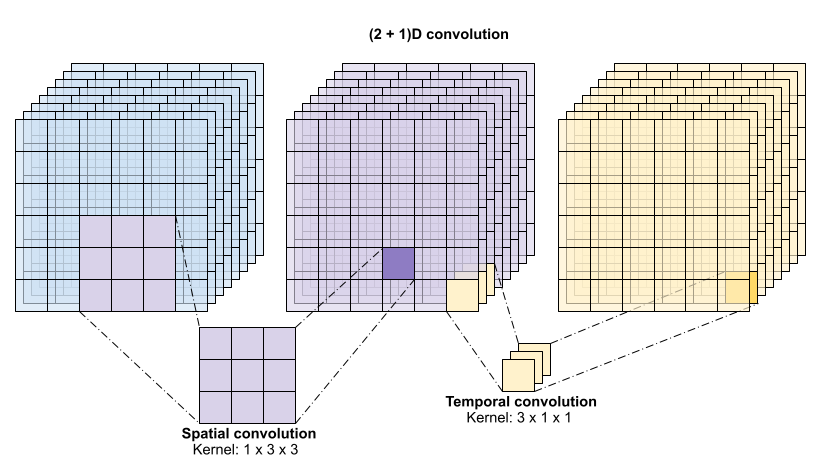

Il vantaggio principale di questo approccio è che riduce il numero di parametri. Nella convoluzione (2 + 1)D la convoluzione spaziale prende i dati della forma `(1, width, height)`, mentre la convoluzione temporale prende i dati della forma `(time, 1, 1)`. Ad esempio, una convoluzione (2 + 1)D con dimensioni del kernel `(3 x 3 x 3)` avrebbe bisogno di matrici di peso di dimensioni `(9 * channels **2) + (3 * channels **2),` meno della metà della convoluzione 3D completa. Questo progetto implementa (2 + 1)D ResNet18, in cui ogni convoluzione nella resnet è sostituita da una convoluzione (2+1)D.

In [13]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 80
WIDTH = 120

In [14]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

Un modello ResNet resnet è costituito da una sequenza di blocchi residui. Un blocco residuo ha due rami. Il ramo principale esegue la calculatoion, ma è difficile per i gradienti passare attraverso. Il ramo residuo bypassa il calcolo principale e per lo più aggiunge solo l'input all'output del ramo principale. I gradienti scorrono facilmente attraverso questo ramo. Pertanto, sarà presente un percorso facile dalla funzione di perdita a uno qualsiasi dei rami principali del blocco residuo. Questo evita il problema del gradiente di fuga.

Creare il ramo principale del blocco residuo con la seguente classe. A differenza della struttura ResNet standard, questo utilizza il layer Conv2Plus1D personalizzato invece di layers.Conv2D.

In [15]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Per aggiungere il ramo residuo al ramo principale deve avere le stesse dimensioni. Il livello di progetto riportato di seguito si occupa dei casi in cui il numero di canali viene modificato sul ramo. In particolare, viene aggiunta una sequenza di strato densamente connesso seguito dalla normalizzazione.

In [16]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Utilizzare `add_residual_block` per introdurre una connessione skip tra i layer del modello.

In [17]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Il ridimensionamento del video è necessario per eseguire il downsampling dei dati. In particolare, il downsampling dei fotogrammi video consente al modello di esaminare parti specifiche dei fotogrammi per rilevare modelli che possono essere specifici per una determinata azione. Attraverso il downsampling, le informazioni non essenziali possono essere scartate. Inoltre, il ridimensionamento del video consentirà una riduzione della dimensionalità e quindi un'elaborazione più rapida attraverso il modello.

In [18]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Uso l'API Funtion di Keras per costruire la rete residua.

In [19]:
input_shape = (None, n_frames, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=32, kernel_size=(5, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (5, 3, 3))
x = layers.BatchNormalization()(x)
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (5, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (5, 3, 3))


x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)

x = layers.Dense(8)(x) # prova a mettere come funzione di attivazione la softmax, cosi da avere la distr. probabilistica | activation=tf.keras.activations.softmax

model = keras.Model(input, x)

In [20]:
frames, label = next(iter(train_ds))
model.build(frames)

In [21]:
# Visualizzo il modello e i suoi parametri
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Traino il modello
Per questo progetto, è stato scelto l'ottimizzatore `tf.keras.optimizers.Adam` e la funzione di loss `tf.keras.losses.SparseCategoricalCrossentropy` che è indicata per i modelli multi-classe. Utilizzare l'argomento delle metriche per visualizzare l'accuratezza delle prestazioni del modello in ogni fase.

In [ ]:
# Restore the weights
model.load_weights('C:/Users/Vincenzo/Desktop/Materiale_Gruppo_24/Sperimentazioni_Reti_3D/3DCNN_120_epoche_laboratorio/Pesi_modello/pesi_3dcnn_120epoche')


model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Modello caricato: accuracy: {:5.2f}%".format(100 * acc))

# Valutare del modello
Utilizzare Keras `model.evaluate` per ottenere la perdita e l'accuratezza sul set di dati di test.

In [ ]:
model.evaluate(test_ds, return_dict=True)

Per visualizzare ulteriormente le prestazioni del modello, utilizzare una matrice di confusione. La matrice di confusione consente di valutare le prestazioni del modello di classificazione oltre l'accuratezza. Per costruire la matrice di confusione per questo problema di classificazione multiclasse, ottenere i valori effettivi nel set di test e i valori previsti.

In [25]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [26]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of BABELE for ' + ds_type)
  ax.set_xlabel('Predicted language')
  ax.set_ylabel('Actual language')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [27]:
fg = FrameGenerator(train_dir, n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

# Rename the labels based on the provided mapping
label_mapping = {
    1: 'Italian',
    2: 'English',
    3: 'German',
    4: 'Spanish',
    5: 'Dutch',
    6: 'Russian',
    7: 'Japanese',
    8: 'French'
}

labels = [int(label) for label in labels]

# Rename the labels using the mapping dictionary
renamed_labels = [label_mapping[label_id] for label_id in labels]

# Print the renamed labels
print(renamed_labels)

['Italian', 'English', 'German', 'Spanish', 'Dutch', 'Russian', 'Japanese', 'French']


In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, renamed_labels, 'test')

I valori di precision e recall per ogni classe possono anche essere calcolati utilizzando una matrice di confusione.

In [29]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [30]:
precision, recall = calculate_classification_metrics(actual, predicted, renamed_labels) # Test dataset

In [ ]:
precision

In [ ]:
recall